<a href="https://colab.research.google.com/github/jaya-deepthi/experiencila3-4/blob/main/adsexperiencial_3%264.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/Reviews.csv')

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df = df.drop(['Id', 'ProfileName','Time','HelpfulnessNumerator','HelpfulnessDenominator','Text','Summary'], axis = 1)

In [ ]:
df.tail()

,ProductId,UserId,Score
437553,B000H154WQ,A1BHDVEBMSH4ZB,5
437554,B000H154WQ,A78VQM66B5N0E,5
437555,B000H154WQ,A3OUOZIDP4E1IU,4
437556,B000H154WQ,A1R4DVHB8HSFUO,5
437557,B000H154WQ,A1Y09POMH03DJF,5


In [ ]:
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  437558
No of columns:  3


In [ ]:
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 ProductId    0
UserId       0
Score        0
dtype: int64


In [ ]:
df[['Score']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Score,437558.0,4.176959,1.314953,1.0,4.0,5.0,5.0,5.0


In [ ]:
def find_min_max_rating():
    print('The minimum rating is: %d' %(df['Score'].min()))
    print('The maximum rating is: %d' %(df['Score'].max()))

find_min_max_rating() 

The minimum rating is: 1
The maximum rating is: 5


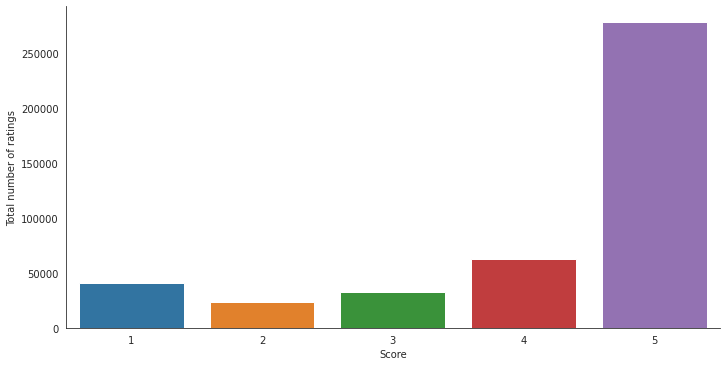

In [ ]:
with sns.axes_style('white'):
    g = sns.factorplot("Score", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [ ]:
print('Number of unique USERS in Raw data = ', df['UserId'].nunique())
print('Number of unique ITEMS in Raw data = ', df['ProductId'].nunique())

Number of unique USERS in Raw data =  211749
Number of unique ITEMS in Raw data =  56537


In [ ]:
most_rated = df.groupby('UserId').size().sort_values(ascending=False)[:10]
most_rated

UserId
A3OXHLG6DIBRW8    352
A1YUL9PCJR3JTY    316
AY12DBB0U420B     308
A281NPSIMI1C2R    257
A1Z54EM24Y40LL    198
A1TMAVN4CEM8U8    168
A3TVZM3ZIXG8YW    163
A2MUGFV2TDQ47K    161
A29JUMRL1US6YP    150
A3PJZ8TU8FDQ1K    132
dtype: int64

In [ ]:
counts = df['UserId'].value_counts()
df_final = df[df['UserId'].isin(counts[counts >= 50].index)]

In [ ]:
df_final.head()

,ProductId,UserId,Score
14,B001GVISJM,A2MUGFV2TDQ47K,5
44,B001EO5QW8,A2G7B7FKP2O2PU,5
46,B001EO5QW8,AQLL2R1PPR46X,5
109,B001REEG6C,AY12DBB0U420B,5
141,B001GVISJW,A2YIO225BTKVPU,4


In [ ]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['UserId'].nunique())
print('Number of unique ITEMS in final data = ', df_final['ProductId'].nunique())

Number of users who have rated 50 or more items = 12680
Number of unique USERS in final data =  150
Number of unique ITEMS in final data =  7076


In [ ]:
final_ratings_matrix = pd.pivot_table(df_final,index=['UserId'], columns = 'ProductId', values = "Score")
final_ratings_matrix.fillna(0,inplace=True)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (150, 7076)
given_num_of_ratings =  11453
possible_num_of_ratings =  1061400
density: 1.08%


In [ ]:
final_ratings_matrix.tail()

ProductId,7310172001,7310172101,B00004CI84,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJS,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084EZ4,B00008JOL0,B00008O36H,B00008WUA9,B000096OIV,B00009ZIY2,B0000A0BS8,B0000AH3UK,B0000AH9XO,...,B00907O6HW,B0090X8IPM,B0090X8JUG,B0091EYBIS,B0092VQ6OW,B0092VQ796,B0092VQ86I,B0092VQ98A,B0092VQ9RQ,B0092VQHDW,B0092VQI54,B0092VQKR0,B0092VQLZG,B0092X7IY2,B0092X7NGU,B0092X7OGY,B0093A5PDK,B0093A5PXK,B0093A5QMA,B0093A5RU6,B0093A5V3O,B0093A5XC8,B0096EZHM2,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B009DS6IF6,B009EQQL5Y,B009EXL6IO,B009GHI6I6,B009IXNU7U,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LT26BC,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AY12DBB0U420B,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AY1EF0GOH80EK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYB4ELCS5AM8P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYOMAHLWRQHUG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZV26LP92E6WU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

UserId,A1080SE9X3ECK0,A11OTLEDSW8ZXD,A132ETQPMHQ585,A13HRSMJ5TOWEZ,A16AXQ11SZA8SQ,A16KK3YHCWE29C,A16WPA6JV83YXT,A175N19FS2B4J,A17HMM1M7T9PJ1,A17V9XL4CWTQ6G,A19123D9G66E0O,A1AEPMPA12GUJ7,A1B05INWIDZ74O,A1BD342U8BF3UC,A1GQAKL9CGQLP1,A1GYEGLX3P2Y7P,A1HOXKR7OKJ1X1,A1HRYC60VTMYC0,A1I85Y08VRZ32Q,A1IU7S4HCK1XK0,A1K82R24ROO2I7,A1KEK09ZA6J9P8,A1LFSTBR7L7PUT,A1LZJZIHUPLDV4,A1ODOGXEYECQQ8,A1P2XYD265YE21,A1PI8VBCXXSGC7,A1Q7A78VSQ5GQ4,A1RLP0R1N8H8C4,A1RRMZKOMZ2M7J,A1SO1PGDNVMLXC,A1T1YSCDW0PD25,A1TMAVN4CEM8U8,A1UQBFCERIP7VJ,A1W415JP5WEAJK,A1WX42M589VAMQ,A1X1CEGHTHMBL1,A1XGFW5016CGQI,A1YJMG0QJXZLD4,A1YUL9PCJR3JTY,...,A3MZNRSDQ32UUH,A3NEAETOSXDBOM,A3NHUQ33CFH3VM,A3OGYXV9S7MJHM,A3OXHLG6DIBRW8,A3OXRFCJI67IMN,A3PD8JD9L4WEII,A3PJZ8TU8FDQ1K,A3QNQQKJTL76H0,A3RR2P5IS3DGPR,A3TVZM3ZIXG8YW,A3VKBFC5K2INR4,A6KL17KKN0A5L,A9NXTC0HTPSDO,AAUICTIUBVU7R,ACYR6O588USK,ADS5APY1NKTL4,AEC90GPFKLAAW,AIQDUKFB4X38M,AJB5P7GVR0MT8,AJD41FBJD9010,AKMEY1BSHSDG7,AKZKG2Z7CNV27,ALDAF4VVLFRHP,ALSAOZ1V546VT,AMQ1MEG334SAP,AMRMK86X3PKXD,APP8XWYYV4PAA,AQLL2R1PPR46X,AQQLWCMRNDFGI,AR7TAEEUDHMUB,ARYSDAZNRXN6G,ATJN4KEHJBOC8,AVFA1JB08RG8G,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYOMAHLWRQHUG,AZV26LP92E6WU
ProductId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7310172001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7310172101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004CI84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
B00004RBDZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004RYGX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


In [ ]:
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)


In [ ]:
def shape():
    print("Test data shape: ", test_data.shape)
    print("Train data shape: ", train_data.shape)
shape() 

Test data shape:  (3804, 3)
Train data shape:  (8876, 3)


# Popularity based recommender

In [ ]:
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'score'},inplace=True)
train_data_grouped.head()

,ProductId,score
0,7310172001,6
1,7310172101,6
2,B00004CI84,2
3,B00004RBDZ,1
4,B00004S1C6,2


In [ ]:
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,ProductId,score,Rank
3512,B002IEZJMA,29,1.0
3511,B002IEVJRY,28,2.0
2263,B001BCVY4W,27,3.0
2264,B001BCVY9W,27,4.0
1367,B000LKXBL4,25,5.0


In [ ]:
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['UserId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [ ]:
find_recom = [15,121,200]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

      UserId   ProductId  score  Rank
3512      15  B002IEZJMA     29   1.0
3511      15  B002IEVJRY     28   2.0
2263      15  B001BCVY4W     27   3.0
2264      15  B001BCVY9W     27   4.0
1367      15  B000LKXBL4     25   5.0


Here is the recommendation for the userId: 121

      UserId   ProductId  score  Rank
3512     121  B002IEZJMA     29   1.0
3511     121  B002IEVJRY     28   2.0
2263     121  B001BCVY4W     27   3.0
2264     121  B001BCVY9W     27   4.0
1367     121  B000LKXBL4     25   5.0


Here is the recommendation for the userId: 200

      UserId   ProductId  score  Rank
3512     200  B002IEZJMA     29   1.0
3511     200  B002IEVJRY     28   2.0
2263     200  B001BCVY4W     27   3.0
2264     200  B001BCVY9W     27   4.0
1367     200  B000LKXBL4     25   5.0




# collaborative filtering model

In [ ]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail()

,index,ProductId,UserId,Score
12675,264750,B002OFZM8O,A250AXLRBVYKB4,5
12676,432747,B001DWEZYQ,A2OWR2PL3DLWS4,5
12677,104645,B000KSTY86,A6KL17KKN0A5L,5
12678,20504,B003PFUNU4,A2YHXAZLCLDT8D,5
12679,201380,B001EO5ZC4,A19123D9G66E0O,4


In [ ]:
pivot_df = pd.pivot_table(df_CF,index=['UserId'], columns = 'ProductId', values = "Score")
pivot_df.fillna(0,inplace=True)
print(pivot_df.shape)
pivot_df.head()

(150, 7076)


ProductId,7310172001,7310172101,B00004CI84,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJS,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084EZ4,B00008JOL0,B00008O36H,B00008WUA9,B000096OIV,B00009ZIY2,B0000A0BS8,B0000AH3UK,B0000AH9XO,...,B00907O6HW,B0090X8IPM,B0090X8JUG,B0091EYBIS,B0092VQ6OW,B0092VQ796,B0092VQ86I,B0092VQ98A,B0092VQ9RQ,B0092VQHDW,B0092VQI54,B0092VQKR0,B0092VQLZG,B0092X7IY2,B0092X7NGU,B0092X7OGY,B0093A5PDK,B0093A5PXK,B0093A5QMA,B0093A5RU6,B0093A5V3O,B0093A5XC8,B0096EZHM2,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B009DS6IF6,B009EQQL5Y,B009EXL6IO,B009GHI6I6,B009IXNU7U,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LT26BC,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11OTLEDSW8ZXD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A132ETQPMHQ585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A13HRSMJ5TOWEZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A16AXQ11SZA8SQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,7310172001,7310172101,B00004CI84,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJS,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084EZ4,B00008JOL0,B00008O36H,B00008WUA9,B000096OIV,B00009ZIY2,B0000A0BS8,B0000AH3UK,B0000AH9XO,...,B0090X8IPM,B0090X8JUG,B0091EYBIS,B0092VQ6OW,B0092VQ796,B0092VQ86I,B0092VQ98A,B0092VQ9RQ,B0092VQHDW,B0092VQI54,B0092VQKR0,B0092VQLZG,B0092X7IY2,B0092X7NGU,B0092X7OGY,B0093A5PDK,B0093A5PXK,B0093A5QMA,B0093A5RU6,B0093A5V3O,B0093A5XC8,B0096EZHM2,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B009DS6IF6,B009EQQL5Y,B009EXL6IO,B009GHI6I6,B009IXNU7U,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LT26BC,B009QEBGIQ,B009RB4GO4,user_index
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A11OTLEDSW8ZXD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A132ETQPMHQ585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A13HRSMJ5TOWEZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A16AXQ11SZA8SQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

ProductId,7310172001,7310172101,B00004CI84,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJS,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084EZ4,B00008JOL0,B00008O36H,B00008WUA9,B000096OIV,B00009ZIY2,B0000A0BS8,B0000AH3UK,B0000AH9XO,...,B00907O6HW,B0090X8IPM,B0090X8JUG,B0091EYBIS,B0092VQ6OW,B0092VQ796,B0092VQ86I,B0092VQ98A,B0092VQ9RQ,B0092VQHDW,B0092VQI54,B0092VQKR0,B0092VQLZG,B0092X7IY2,B0092X7NGU,B0092X7OGY,B0093A5PDK,B0093A5PXK,B0093A5QMA,B0093A5RU6,B0093A5V3O,B0093A5XC8,B0096EZHM2,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B009DS6IF6,B009EQQL5Y,B009EXL6IO,B009GHI6I6,B009IXNU7U,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LT26BC,B009QEBGIQ,B009RB4GO4
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


svd method

In [ ]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,7310172001,7310172101,B00004CI84,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJS,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084EZ4,B00008JOL0,B00008O36H,B00008WUA9,B000096OIV,B00009ZIY2,B0000A0BS8,B0000AH3UK,B0000AH9XO,...,B00907O6HW,B0090X8IPM,B0090X8JUG,B0091EYBIS,B0092VQ6OW,B0092VQ796,B0092VQ86I,B0092VQ98A,B0092VQ9RQ,B0092VQHDW,B0092VQI54,B0092VQKR0,B0092VQLZG,B0092X7IY2,B0092X7NGU,B0092X7OGY,B0093A5PDK,B0093A5PXK,B0093A5QMA,B0093A5RU6,B0093A5V3O,B0093A5XC8,B0096EZHM2,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B009DS6IF6,B009EQQL5Y,B009EXL6IO,B009GHI6I6,B009IXNU7U,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LT26BC,B009QEBGIQ,B009RB4GO4
0,0.070764,0.070764,0.054173,-0.012447,0.054173,-0.046278,-0.090856,0.021922,-0.113570,-0.218773,0.096952,-0.097452,0.126952,0.008529,0.008529,0.008529,0.006396,0.010661,0.010661,0.008529,0.006396,0.002132,0.008529,0.008529,0.010661,0.004264,0.010661,0.006396,-0.113570,-0.105041,0.008169,0.112453,-0.052418,0.002071,0.026349,0.518430,0.008529,-0.053050,-0.102126,0.010661,...,0.015809,-0.804748,0.074612,-0.079912,-1.341190e-16,-1.341190e-16,-1.341190e-16,-2.377627e-16,-2.377627e-16,-1.341190e-16,-1.341190e-16,-2.636736e-16,-2.636736e-16,-0.066313,-0.066313,-0.066313,-1.295545e-16,-1.295545e-16,-1.341190e-16,-1.341190e-16,-1.341190e-16,-2.636736e-16,0.125192,0.006247,0.000141,-0.008634,0.010661,0.010540,-0.001891,0.010661,-0.000786,0.081972,-0.079602,-0.079602,-0.079602,0.079224,-0.079602,0.074612,0.144625,0.002840
1,0.025890,0.025890,-0.010814,-0.021917,-0.010814,0.048507,0.048440,-0.020911,0.060550,-0.171769,0.003381,-0.334981,0.424390,-0.011634,-0.011634,-0.011634,-0.008725,-0.014542,-0.014542,-0.011634,-0.008725,-0.002908,-0.011634,-0.011634,-0.014542,-0.005817,-0.014542,-0.008725,0.060550,0.048916,-0.028044,-0.003027,-0.218265,-0.002790,0.180797,0.031234,-0.011634,-0.006294,-0.006005,-0.014542,...,0.108478,-0.191362,-0.003970,0.198380,2.836029e-17,2.836029e-17,2.836029e-17,9.578736e-17,9.578736e-17,2.836029e-17,2.836029e-17,1.126441e-16,1.126441e-16,-0.007868,-0.007868,-0.007868,8.428384e-17,8.428384e-17,2.836029e-17,2.836029e-17,2.836029e-17,1.126441e-16,0.045865,0.002693,-0.001752,-0.011385,-0.014542,0.072319,-0.043303,-0.014542,-0.003151,0.091483,0.080505,0.080505,0.080505,-0.120528,0.080505,-0.003970,0.131906,0.233815
2,-0.009466,-0.009466,0.009605,0.024390,0.009605,-0.003748,0.011505,0.020050,0.014381,-0.018704,-0.026939,-0.001989,0.003144,-0.004506,-0.004506,-0.004506,-0.003380,-0.005633,-0.005633,-0.004506,-0.003380,-0.001127,-0.004506,-0.004506,-0.005633,-0.002253,-0.005633,-0.003380,0.014381,0.009875,0.048037,-0.021778,0.005890,-0.000414,0.001308,0.022595,-0.004506,-0.008876,0.002954,-0.005633,...,0.000785,-0.072109,-0.002581,0.030285,4.818894e-17,4.818894e-17,4.818894e-17,8.744922e-17,8.744922e-17,4.818894e-17,4.818894e-17,9.726429e-17,9.726429e-17,-0.011095,-0.011095,-0.011095,4.907535e-17,4.907535e-17,4.818894e-17,4.818894e-17,4.818894e-17,9.726429e-17,-0.021605,0.015336,0.000982,0.007185,-0.005633,0.000523,0.002347,-0.005633,0.000036,0.001727,0.004050,0.004050,0.004050,0.019186,0.004050,-0.002581,-0.022017,0.007068
3,-0.001037,-0.001037,-0.012930,-0.020758,-0.012930,-0.019277,0.000615,0.035027,0.000769,-0.013912,-0.027626,-0.015558,0.014780,0.047955,0.047955,0.047955,0.035966,0.059944,0.059944,0.047955,0.035966,0.011989,0.047955,0.047955,0.059944,0.023978,0.059944,0.035966,0.000769,0.048724,-0.000323,-0.019569,-0.004035,-0.000117,0.012108,0.010411,0.047955,-0.014094,0.007616,0.059944,...,0.007265,-0.001999,0.001996,0.063617,2.118909e-16,2.118909e-16,2.118909e-16,3.436533e-16,3.436533e-16,2.118909e-16,2.118909e-16,3.765939e-16,3.765939e-16,-0.017618,-0.017618,-0.017618,1.647030e-16,1.647030e-16,2.118909e-16,2.118909e-16,2.118909e-16,3.7

In [ ]:
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
userID = 121
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 121):

                   user_ratings  user_predictions
Recommended Items                                
B0062A87HA                  0.0          0.156973
B000HDI5O8                  0.0          0.156973
B001EQ55RW                  0.0          0.152450
B001EO6E0Q                  0.0          0.136049
B00823T1K2                  0.0          0.134759


# evaluating the collaborative filtering model

In [ ]:
final_ratings_matrix.head()

ProductId,7310172001,7310172101,B00004CI84,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJS,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084EZ4,B00008JOL0,B00008O36H,B00008WUA9,B000096OIV,B00009ZIY2,B0000A0BS8,B0000AH3UK,B0000AH9XO,...,B00907O6HW,B0090X8IPM,B0090X8JUG,B0091EYBIS,B0092VQ6OW,B0092VQ796,B0092VQ86I,B0092VQ98A,B0092VQ9RQ,B0092VQHDW,B0092VQI54,B0092VQKR0,B0092VQLZG,B0092X7IY2,B0092X7NGU,B0092X7OGY,B0093A5PDK,B0093A5PXK,B0093A5QMA,B0093A5RU6,B0093A5V3O,B0093A5XC8,B0096EZHM2,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B009DS6IF6,B009EQQL5Y,B009EXL6IO,B009GHI6I6,B009IXNU7U,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LT26BC,B009QEBGIQ,B009RB4GO4
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11OTLEDSW8ZXD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A132ETQPMHQ585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A13HRSMJ5TOWEZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A16AXQ11SZA8SQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ProductId
7310172001    0.066667
7310172101    0.066667
B00004CI84    0.053333
B00004RBDZ    0.033333
B00004RYGX    0.053333
dtype: float64

In [ ]:
# Predicted ratings 
preds_df.head()

ProductId,7310172001,7310172101,B00004CI84,B00004RBDZ,B00004RYGX,B00004S1C6,B000052Y74,B00005344V,B0000691JF,B00006IDK9,B00008434E,B000084DWM,B000084E66,B000084EJQ,B000084EJS,B000084EJY,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,B000084EKG,B000084EKO,B000084EKW,B000084EKY,B000084ETV,B000084EZ4,B00008JOL0,B00008O36H,B00008WUA9,B000096OIV,B00009ZIY2,B0000A0BS8,B0000AH3UK,B0000AH9XO,...,B00907O6HW,B0090X8IPM,B0090X8JUG,B0091EYBIS,B0092VQ6OW,B0092VQ796,B0092VQ86I,B0092VQ98A,B0092VQ9RQ,B0092VQHDW,B0092VQI54,B0092VQKR0,B0092VQLZG,B0092X7IY2,B0092X7NGU,B0092X7OGY,B0093A5PDK,B0093A5PXK,B0093A5QMA,B0093A5RU6,B0093A5V3O,B0093A5XC8,B0096EZHM2,B0096UUUAU,B00975HC9G,B009858H6M,B0098QPNJA,B009DS6IF6,B009EQQL5Y,B009EXL6IO,B009GHI6I6,B009IXNU7U,B009KAQW12,B009KAQZ9G,B009KAQZIM,B009KOHGEK,B009KP6HBM,B009LT26BC,B009QEBGIQ,B009RB4GO4
0,0.070764,0.070764,0.054173,-0.012447,0.054173,-0.046278,-0.090856,0.021922,-0.113570,-0.218773,0.096952,-0.097452,0.126952,0.008529,0.008529,0.008529,0.006396,0.010661,0.010661,0.008529,0.006396,0.002132,0.008529,0.008529,0.010661,0.004264,0.010661,0.006396,-0.113570,-0.105041,0.008169,0.112453,-0.052418,0.002071,0.026349,0.518430,0.008529,-0.053050,-0.102126,0.010661,...,0.015809,-0.804748,0.074612,-0.079912,-1.341190e-16,-1.341190e-16,-1.341190e-16,-2.377627e-16,-2.377627e-16,-1.341190e-16,-1.341190e-16,-2.636736e-16,-2.636736e-16,-0.066313,-0.066313,-0.066313,-1.295545e-16,-1.295545e-16,-1.341190e-16,-1.341190e-16,-1.341190e-16,-2.636736e-16,0.125192,0.006247,0.000141,-0.008634,0.010661,0.010540,-0.001891,0.010661,-0.000786,0.081972,-0.079602,-0.079602,-0.079602,0.079224,-0.079602,0.074612,0.144625,0.002840
1,0.025890,0.025890,-0.010814,-0.021917,-0.010814,0.048507,0.048440,-0.020911,0.060550,-0.171769,0.003381,-0.334981,0.424390,-0.011634,-0.011634,-0.011634,-0.008725,-0.014542,-0.014542,-0.011634,-0.008725,-0.002908,-0.011634,-0.011634,-0.014542,-0.005817,-0.014542,-0.008725,0.060550,0.048916,-0.028044,-0.003027,-0.218265,-0.002790,0.180797,0.031234,-0.011634,-0.006294,-0.006005,-0.014542,...,0.108478,-0.191362,-0.003970,0.198380,2.836029e-17,2.836029e-17,2.836029e-17,9.578736e-17,9.578736e-17,2.836029e-17,2.836029e-17,1.126441e-16,1.126441e-16,-0.007868,-0.007868,-0.007868,8.428384e-17,8.428384e-17,2.836029e-17,2.836029e-17,2.836029e-17,1.126441e-16,0.045865,0.002693,-0.001752,-0.011385,-0.014542,0.072319,-0.043303,-0.014542,-0.003151,0.091483,0.080505,0.080505,0.080505,-0.120528,0.080505,-0.003970,0.131906,0.233815
2,-0.009466,-0.009466,0.009605,0.024390,0.009605,-0.003748,0.011505,0.020050,0.014381,-0.018704,-0.026939,-0.001989,0.003144,-0.004506,-0.004506,-0.004506,-0.003380,-0.005633,-0.005633,-0.004506,-0.003380,-0.001127,-0.004506,-0.004506,-0.005633,-0.002253,-0.005633,-0.003380,0.014381,0.009875,0.048037,-0.021778,0.005890,-0.000414,0.001308,0.022595,-0.004506,-0.008876,0.002954,-0.005633,...,0.000785,-0.072109,-0.002581,0.030285,4.818894e-17,4.818894e-17,4.818894e-17,8.744922e-17,8.744922e-17,4.818894e-17,4.818894e-17,9.726429e-17,9.726429e-17,-0.011095,-0.011095,-0.011095,4.907535e-17,4.907535e-17,4.818894e-17,4.818894e-17,4.818894e-17,9.726429e-17,-0.021605,0.015336,0.000982,0.007185,-0.005633,0.000523,0.002347,-0.005633,0.000036,0.001727,0.004050,0.004050,0.004050,0.019186,0.004050,-0.002581,-0.022017,0.007068
3,-0.001037,-0.001037,-0.012930,-0.020758,-0.012930,-0.019277,0.000615,0.035027,0.000769,-0.013912,-0.027626,-0.015558,0.014780,0.047955,0.047955,0.047955,0.035966,0.059944,0.059944,0.047955,0.035966,0.011989,0.047955,0.047955,0.059944,0.023978,0.059944,0.035966,0.000769,0.048724,-0.000323,-0.019569,-0.004035,-0.000117,0.012108,0.010411,0.047955,-0.014094,0.007616,0.059944,...,0.007265,-0.001999,0.001996,0.063617,2.118909e-16,2.118909e-16,2.118909e-16,3.436533e-16,3.436533e-16,2.118909e-16,2.118909e-16,3.765939e-16,3.765939e-16,-0.017618,-0.017618,-0.017618,1.647030e-16,1.647030e-16,2.118909e-16,2.118909e-16,2.118909e-16,3.7

In [ ]:
# Average PREDICTED rating for each item
preds_df.mean().head()

ProductId
7310172001    0.004257
7310172101    0.004257
B00004CI84    0.051361
B00004RBDZ    0.039223
B00004RYGX    0.051361
dtype: float64

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(7076, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductId,,,
7310172001,0.066667,0.004257,0
7310172101,0.066667,0.004257,1
B00004CI84,0.053333,0.051361,2
B00004RBDZ,0.033333,0.039223,3
B00004RYGX,0.053333,0.051361,4


In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01345 



In [ ]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 130
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 130):

                   user_ratings  user_predictions
Recommended Items                                
B000H7LVKY                  0.0          0.361531
B001LG940E                  0.0          0.351743
B0051COPH6                  0.0          0.296433
B00430B73W                  0.0          0.294948
B000FL08B0                  0.0          0.288040


here the first model i did was popularity based model so it not personalised while the collaborative filterng model is personalized.